In [40]:
import pandas
s_dfm = pandas.read_csv('students.csv')

In [41]:
len(s_dfm)

318

In [42]:
s_dfm.head()

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


In [43]:
s_dfm.student_id

0        1
1        2
2        3
3        4
4        5
      ... 
313    314
314    315
315    316
316    317
317    318
Name: student_id, Length: 318, dtype: int64

In [44]:
s_dfm.student_id.max()

318

In [45]:
s_dfm.student_id.min()

1

In [46]:
set(range(1,319)) == set(s_dfm.student_id.tolist())

True

In [47]:
s_dfm.gender.value_counts()

0    160
1    158
Name: gender, dtype: int64

In [48]:
s_dfm.score.describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

In [49]:
%matplotlib inline

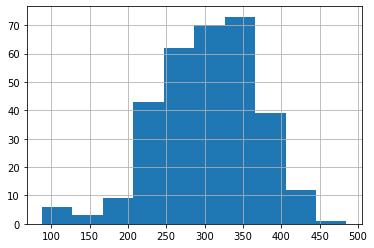

In [50]:
s_dfm.score.hist()

In [51]:
s_dfm.leader_flag.value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [52]:
s_dfm.support_flag.value_counts()

0    314
1      4
Name: support_flag, dtype: int64

In [53]:
s_pair_dfm = pandas.read_csv('student_pairs.csv')
print(len(s_pair_dfm))

3


In [54]:
s_pair_dfm.head()

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


In [55]:
import pulp

In [56]:
# 数理モデルのインスタンス作成
prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

In [57]:
# 生徒のリスト
S = s_dfm.student_id.tolist()

In [58]:
# クラスのリスト
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [59]:
# 生徒とクラスのペアのリスト
SC = [(s,c) for s in S for c in C]

# 生徒をどのクラスに割り当てるかを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

In [60]:
# (1)各生徒は１つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum([x[s,c] for c in C]) == 1

In [61]:
# (2)各クラスの生徒の人数は39人以上、40人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S]) >= 39
    prob += pulp.lpSum([x[s,c] for s in S]) <= 40

In [62]:
# 男子生徒のリスト
S_male = [row.student_id for row in s_dfm.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_dfm.itertuples() if row.gender == 0]

# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

In [63]:
# 学力を辞書表現に変換
score = dict([(row.student_id, row.score) for row in s_dfm.itertuples()])

# 平均点の算出
score_mean = s_dfm.score.mean()    
    
# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。    
for c in C:
    prob += (score_mean - 10) * pulp.lpSum([x[s,c] for s in S]) <= pulp.lpSum([x[s,c]*score[s] for s in S]) 
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s,c] for s in S])

In [64]:
# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_dfm.itertuples() if row.leader_flag == 1]

# (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_leader]) >= 2

In [65]:
# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_dfm.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_support]) <= 1

In [66]:
# 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_dfm.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない。
for s1, s2 in SS:
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

In [67]:
status = prob.solve()
print(status)
print(pulp.LpStatus[status])

1
Optimal


In [68]:
# 最適化結果の表示
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value()==1]

            
for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Class: A
Num: 40
Student: [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 101, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298]

Class: B
Num: 39
Student: [1, 11, 15, 43, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 121, 124, 127, 134, 149, 159, 167, 170, 176, 190, 203, 213, 220, 222, 231, 238, 245, 270, 275, 276, 283, 287, 290, 317]

Class: C
Num: 40
Student: [3, 14, 23, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 107, 122, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 274, 277, 278, 301, 318]

Class: D
Num: 40
Student: [10, 13, 16, 20, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 128, 139, 140, 142, 146, 158, 161, 175, 183, 192, 198, 200, 221, 225, 235, 241, 252, 255, 256, 257, 266, 284, 293, 316]

Class: E
Num: 40
Student: [4, 5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 115, 129, 132, 141, 143, 150, 154, 164, 166, 184, 189, 195, 196, 197, 24

In [86]:
import pandas
import pulp

s_dfm = pandas.read_csv('students.csv')
s_pair_dfm = pandas.read_csv('student_pairs.csv')

prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

# 生徒のリスト
S = s_dfm.student_id.tolist()

# クラスのリスト
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# 生徒とクラスのペアのリスト
SC = [(s,c) for s in S for c in C]

# 生徒をどのクラスに割り当てるを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

# (1)各生徒は１つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum([x[s,c] for c in C]) == 1

# (2)各クラスの生徒の人数は39人以上、40人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S]) >= 39
    prob += pulp.lpSum([x[s,c] for s in S]) <= 40

# 男子生徒のリスト
S_male = [row.student_id for row in s_dfm.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_dfm.itertuples() if row.gender == 0]

# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

# 学力を辞書表現に変換
score = dict([(row.student_id, row.score) for row in s_dfm.itertuples()])

# 平均点の算出
score_mean = s_dfm.score.mean()

# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。
for c in C:
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) >= (score_mean - 10) * pulp.lpSum([x[s,c] for s in S])
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s,c] for s in S])

# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_dfm.itertuples() if row.leader_flag == 1]

# (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_dfm.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_support]) <= 1

    # 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_dfm.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない。
for row in s_pair_dfm.itertuples():
    s1 = row.student_id1
    s2 = row.student_id2
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

# 初期クラス編成のデータを作成
# 学力をもとに順位を付与
s_dfm['score_rank'] = s_dfm.score.rank(ascending=False, method='first') 


# 学力順にクラス編成し、init_assigned_classカラムを作成
class_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H'}
s_dfm['init_assigned_class'] = s_dfm.score_rank.map(lambda x:x % 8).map(class_dic)
s_dfm.head()        
        
    
# init_flagを作成
init_flag = dict([((s,c), 0)for s in S for c in C])
for row in s_dfm.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1
    
    
# 目的関数:初期クラス編成と最適化結果のクラス編成をできるだけ一致させる
prob.objective = pulp.lpSum([x[s,c] * init_flag[s,c] for s,c in SC])        


# 求解
status = prob.solve()
print('Status:', pulp.LpStatus[status])

# 最適化結果の表示
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value()==1]

for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Status: Optimal
Class: A
Num: 40
Student: [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]

Class: B
Num: 39
Student: [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]

Class: C
Num: 40
Student: [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]

Class: D
Num: 40
Student: [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]

Class: E
Num: 39
Student: [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203

In [87]:
for s in S:
    # 割り当てられたクラスを取得
    assigned_class = [x[s,c].value() for c in C if x[s,c].value()==1]

    # 1つのクラスに割り当てられているか確認
    if len(assigned_class) != 1:
        print('error:', s, c)

In [88]:
# 検証用のデータフレームの用意
result_dfm = s_dfm.copy()

# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {}
for s in S:
    S2C[s] = [c for c in C if x[s,c].value()==1][0]

# 生徒データに各生徒が度のクラスに割り当てられたかの情報を結合            
result_dfm['assigned_class'] = result_dfm.student_id.map(S2C)
result_dfm.head(5)

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,H
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,D


In [72]:
result_dfm.groupby('assigned_class')['student_id'].count()

assigned_class
A    40
B    40
C    40
D    40
E    40
F    39
G    40
H    39
Name: student_id, dtype: int64

In [73]:
result_dfm.groupby(['assigned_class', 'gender'])['student_id'].count()

assigned_class  gender
A               0         20
                1         20
B               0         20
                1         20
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         19
G               0         20
                1         20
H               0         20
                1         19
Name: student_id, dtype: int64

In [74]:
result_dfm.groupby('assigned_class')['score'].mean()

assigned_class
A    313.400000
B    293.825000
C    311.250000
D    313.250000
E    295.650000
F    295.666667
G    311.900000
H    293.769231
Name: score, dtype: float64

In [75]:
result_dfm[result_dfm.leader_flag==1].groupby(['assigned_class'])['student_id'].count()

assigned_class
A    3
B    2
C    2
D    2
E    2
F    2
G    2
H    2
Name: student_id, dtype: int64

In [76]:
result_dfm[result_dfm.support_flag==1].groupby(['assigned_class'])['student_id'].count()

assigned_class
B    1
C    1
E    1
G    1
Name: student_id, dtype: int64

In [77]:
for i, ss in enumerate(SS):
    s1, s2 = ss
    print('case:',i)
    c1 = S2C[s1]
    c2 = S2C[s2]
    print('s1:{}-{}'.format(s1, c1))
    print('s2:{}-{}'.format(s2, c2))
    print('')

case: 0
s1:118-G
s2:189-E

case: 1
s1:72-E
s2:50-B

case: 2
s1:314-H
s2:233-A



In [78]:
import matplotlib.pyplot as plt

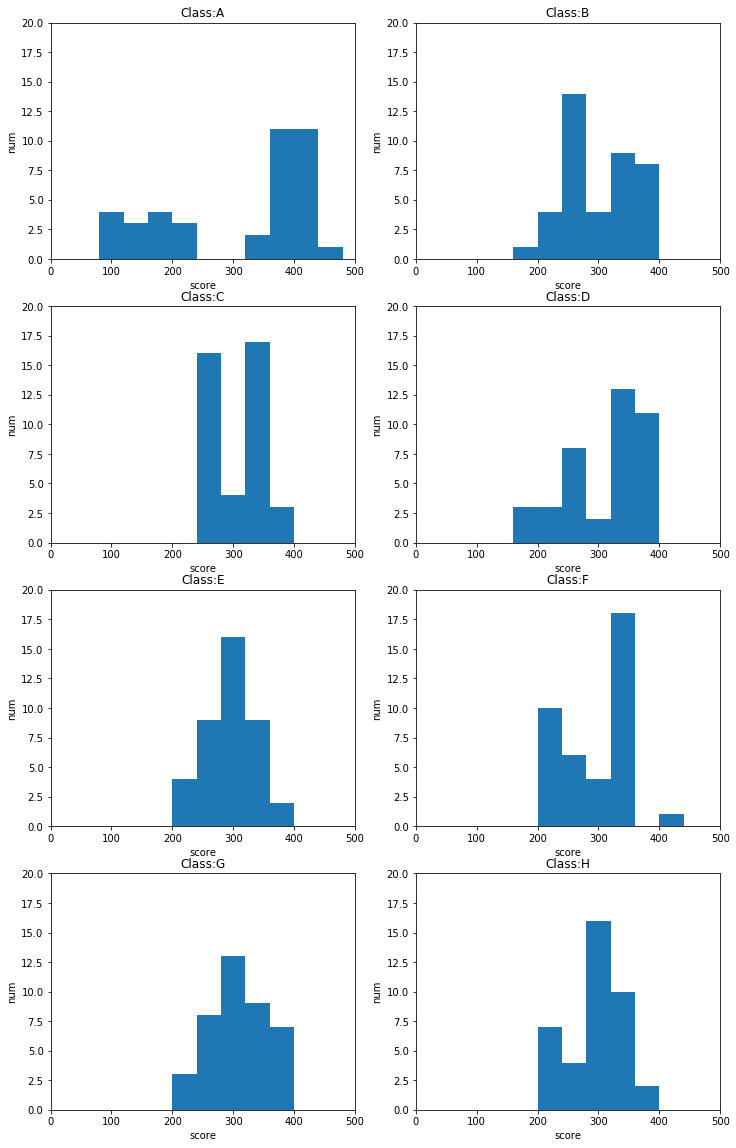

In [79]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_dfm = result_dfm[result_dfm.assigned_class==c]
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(cls_dfm.score, bins=range(0,500,40))
    ax.set_title('Class:{:s}'.format(c))
    ax.set_xlim(0, 500)
    ax.set_ylim(0,20)
    ax.set_xlabel('score')
    ax.set_ylabel('num')

In [80]:
# 初期クラス編成のデータを作成
# 学力をもとに順位を付与
s_dfm['score_rank'] = s_dfm.score.rank(ascending=False, method='first') 

# 学力順にクラス編成し、init_assigned_classカラムを作成
class_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H'}
s_dfm['init_assigned_class'] = s_dfm.score_rank.map(lambda x:x % 8).map(class_dic)
s_dfm.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H
3,4,0,0,0,301,172.0,E
4,5,1,0,0,317,147.0,D


In [81]:
# init_flagを作成
init_flag = dict([((s,c), 0)for s in S for c in C])
for row in s_dfm.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1

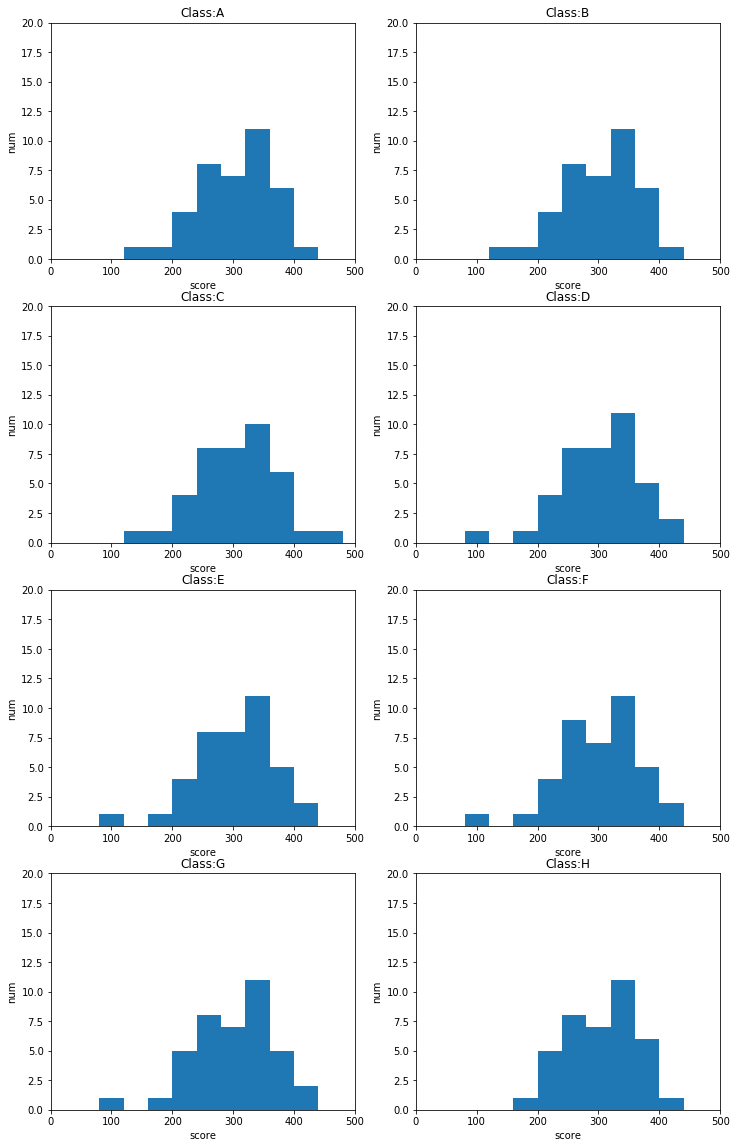

In [82]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_dfm = s_dfm[s_dfm.init_assigned_class==c]
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(cls_dfm.score, bins=range(0,500,40))
    ax.set_title('Class:{:s}'.format(c))
    ax.set_xlim(0, 500)
    ax.set_ylim(0,20)
    ax.set_xlabel('score')
    ax.set_ylabel('num')

In [83]:
# 目的関数:初期クラス編成と最適化結果のクラス編成をできるだけ一致させる
prob.objective = pulp.lpSum([x[s,c] * init_flag[s,c] for s,c in SC])

In [84]:
# 検証用のデータフレームの用意
result_dfm2 = s_dfm.copy()

# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {}
for s in S:
    S2C[s] = [c for c in C if x[s,c].value()==1][0]

# 生徒データに各生徒が度のクラスに割り当てられたかの情報を結合            
result_dfm2['assigned_class'] = result_dfm2.student_id.map(S2C)
result_dfm2.head(5)

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,C
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,C
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,E


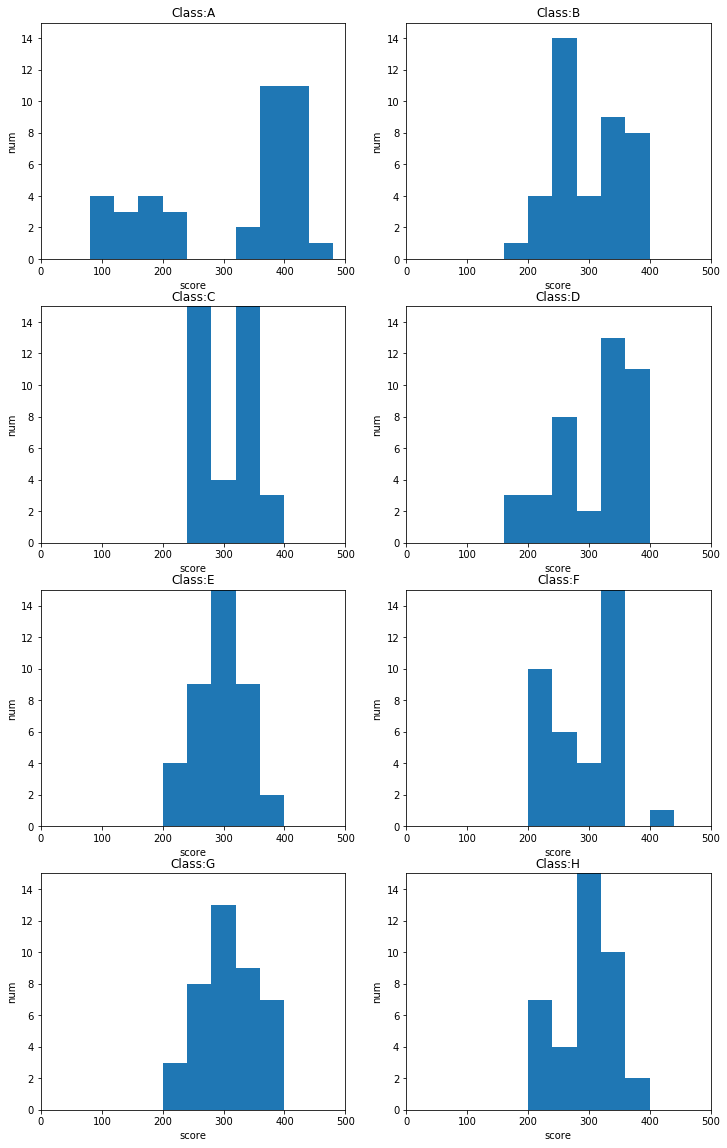

In [85]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_dfm = result_dfm2[result_dfm2.assigned_class==c]
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(cls_dfm.score, bins=range(0,500,40))
    ax.set_title('Class:{:s}'.format(c))
    ax.set_xlim(0, 500)
    ax.set_ylim(0,15)
    ax.set_xlabel('score')
    ax.set_ylabel('num')

In [92]:
import pandas
import pulp

s_dfm = pandas.read_csv('students.csv')
s_pair_dfm = pandas.read_csv('student_pairs.csv')

prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

# 生徒のリスト
S = s_dfm.student_id.tolist()

# クラスのリスト
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# 生徒とクラスのペアのリスト
SC = [(s,c) for s in S for c in C]

# 生徒をどのクラスに割り当てるを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

# (1)各生徒は１つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum([x[s,c] for c in C]) == 1

# (2)各クラスの生徒の人数は39人以上、40人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S]) >= 39
    prob += pulp.lpSum([x[s,c] for s in S]) <= 40

# 男子生徒のリスト
S_male = [row.student_id for row in s_dfm.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_dfm.itertuples() if row.gender == 0]

# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

# 学力を辞書表現に変換
score = dict([(row.student_id, row.score) for row in s_dfm.itertuples()])

# 平均点の算出
score_mean = s_dfm.score.mean()

# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。
for c in C:
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) >= (score_mean - 10) * pulp.lpSum([x[s,c] for s in S])
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s,c] for s in S])

# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_dfm.itertuples() if row.leader_flag == 1]

# (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_dfm.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_support]) <= 1

    # 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_dfm.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない。
for row in s_pair_dfm.itertuples():
    s1 = row.student_id1
    s2 = row.student_id2
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

#ここから修正する        
        
        
# 初期クラス編成のデータを作成
# 学力をもとに順位を付与
s_dfm['score_rank'] = s_dfm.score.rank(ascending=False, method='first') 


# 学力順にクラス編成し、init_assigned_classカラムを作成
class_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H'}
s_dfm['init_assigned_class'] = s_dfm.score_rank.map(lambda x:x % 8).map(class_dic)
s_dfm.head()        
        
    
# init_flagを作成
init_flag = dict([((s,c), 0)for s in S for c in C])
for row in s_dfm.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1
    
    
# 目的関数:初期クラス編成と最適化結果のクラス編成をできるだけ一致させる
prob.objective = pulp.lpSum([x[s,c] * init_flag[s,c] for s,c in SC])        


# 求解
status = prob.solve()
print('Status:', pulp.LpStatus[status])

# 最適化結果の表示
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value()==1]

for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Status: Optimal
Class: A
Num: 40
Student: [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]

Class: B
Num: 39
Student: [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]

Class: C
Num: 40
Student: [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]

Class: D
Num: 40
Student: [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]

Class: E
Num: 39
Student: [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203

In [93]:
# 検証用のデータフレームの用意
result_dfm2 = s_dfm.copy()

# 各生徒がどのクラスに割り当てられたかの情報を辞書に格納
S2C = {}
for s in S:
    S2C[s] = [c for c in C if x[s,c].value()==1][0]

# 生徒データに各生徒が度のクラスに割り当てられたかの情報を結合            
result_dfm2['assigned_class'] = result_dfm2.student_id.map(S2C)
result_dfm2.head(5)

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,H
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,D


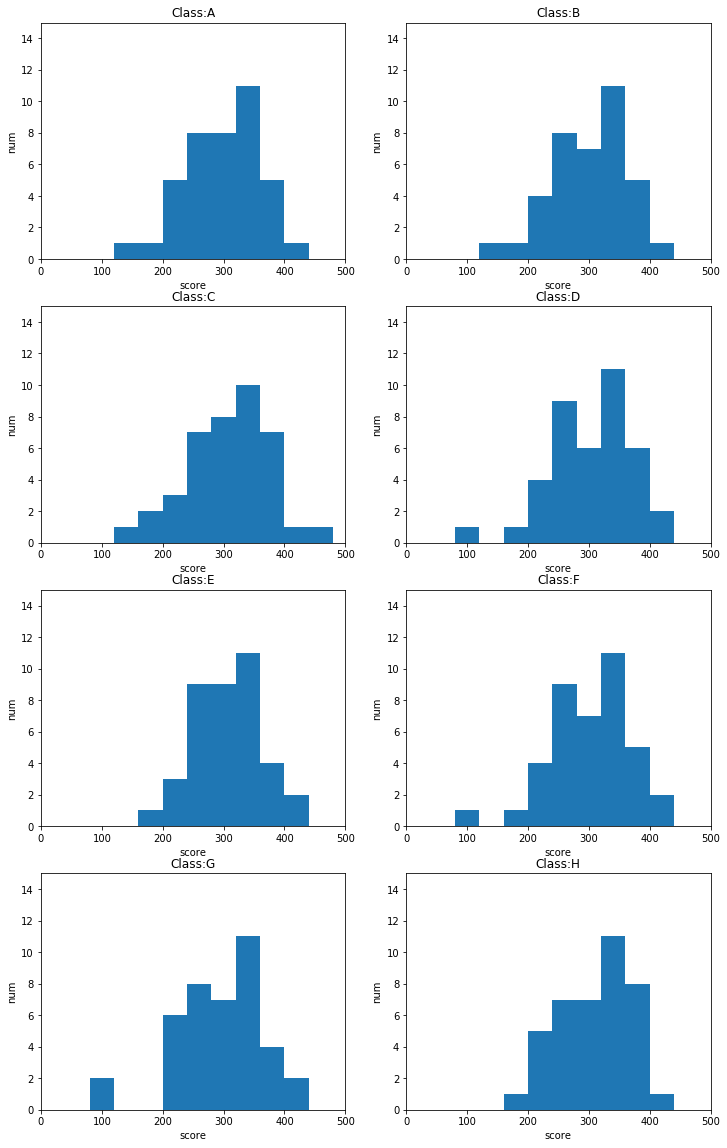

In [94]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_dfm = result_dfm2[result_dfm2.assigned_class==c]
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(cls_dfm.score, bins=range(0,500,40))
    ax.set_title('Class:{:s}'.format(c))
    ax.set_xlim(0, 500)
    ax.set_ylim(0,15)
    ax.set_xlabel('score')
    ax.set_ylabel('num')